# Module 4: Visual Lane Servoing and Lane Localization

Now that we have our basic motion and camera imaging that we can get from our robot, we want to combine the two where it can travel down a road while staying within the lanes.

This Module should follow Module 5: Road Sign Detection

In [ ]:
from jetbot import Robot, Camera, bgr8_to_jpeg
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
import time

robot = Robot()
camera = Camera.instance()

ModuleNotFoundError: No module named 'jetbot'

In [ ]:
def detect_lane_markings(image: np.ndarray):
    """
    Args:
        image: An image from the robot's camera in the BGR color space (numpy.ndarray)
    Return:
        left_masked_img:   Masked image for the dashed-yellow line (numpy.ndarray)
        right_masked_img:  Masked image for the solid-white line (numpy.ndarray)
    """
    h, w, _ = image.shape
    # print(image.shape)

    imgbgr = image

    # Convert the image to HSV for any color-based filtering
    imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

    # Most of our operations will be performed on the grayscale version
    imggray = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

    horizon_X = 130
    mask_ground = np.zeros((h, w), dtype=np.uint8)
    mask_ground[int(h - horizon_X) :, :] = 1
    # print(h," " ,w," " ,int(h - horizon_X[0]))

    sigma = 8  # CHANGE ME

    # Smooth the image using a Gaussian kernel
    img_gaussian_filter = cv2.GaussianBlur(imggray, (0, 0), sigma)

    # Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
    sobelx = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 0, 1)

    # Compute the magnitude of the gradients
    Gmag = np.sqrt(sobelx * sobelx + sobely * sobely)

    threshold_left = 5  # CHANGE ME
    mask_mag_left = Gmag > threshold_left
    threshold_right = 25
    mask_mag_right = Gmag > threshold_right

    white_lower_hsv = np.array([15, 3, 166])  # CHANGE ME
    white_upper_hsv = np.array([179, 116, 255])  # CHANGE ME
    yellow_lower_hsv = np.array([10, 75, 50])        # CHANGE ME
    yellow_upper_hsv = np.array([35, 255, 255])  # CHANGE ME

    mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    mask_left = np.ones(sobelx.shape)
    mask_left[:, int(np.floor(w / 2)) : w + 1] = 0
    mask_right = np.ones(sobelx.shape)
    mask_right[:, 0 : int(np.floor(w / 2))] = 0

    mask_sobelx_pos = sobelx > 0
    mask_sobelx_neg = sobelx < 0
    mask_sobely_neg = sobely < 0

    mask_left_edge = mask_ground * mask_left * mask_mag_left * mask_sobelx_neg * mask_sobely_neg * mask_yellow
    mask_right_edge = mask_ground * mask_right * mask_mag_right * mask_sobelx_pos * mask_sobely_neg * mask_white
    mask_lanes = cv2.bitwise_or(mask_left_edge, mask_right_edge)
    masked_image = cv2.bitwise_and(image, image, mask=mask_ground)
    # display(Image(data=bgr8_to_jpeg(mask_lanes)))
    # display(Image(data=bgr8_to_jpeg(image)))

    return mask_left_edge, mask_right_edge

In [ ]:
def get_steer_matrix_left_lane_markings(shape: Tuple[int, int]) -> np.ndarray:
    """
    Args:
        shape:              The shape of the steer matrix.

    Return:
        steer_matrix_left:  The steering (angular rate) matrix for Braitenberg-like control
                            using the masked left lane markings (numpy.ndarray)
    """

    width = int(shape[1] / 2)
    height = int(shape[0])

    steer_matrix_left_lane = np.zeros((height, shape[1]))

    iterable = (x for x in range(width))
    steer_matrix_left_lane_unit = np.fromiter(iterable, float)

    if steer_matrix_left_lane_unit.max() != 0:
        steer_matrix_left_lane_unit /= steer_matrix_left_lane_unit.max()

    steer_matrix_left_lane[:, :width] = np.tile(steer_matrix_left_lane_unit, (height, 1)) * -0.3
    steer_matrix_left_lane[int(height * 0.5) : -int(height * 0.2), int(width / 2) : width] = (
        steer_matrix_left_lane[int(height * 0.5) : -int(height * 0.2), int(width / 2) : width] * 2.0
    )

    return steer_matrix_left_lane

In [ ]:
while True:
    clear_output(wait=True)
    left, right = detect_lane_markings(camera.value)
    time.sleep(0.01)

# AELMIGER

In [ ]:
from jetbot import Robot, Camera, bgr8_to_jpeg
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
import time

robot = Robot()
camera = Camera.instance()

In [ ]:
import numpy as np
import cv2
from scipy.optimize import lsq_linear
import CP_constants as const
from collections import deque

In [ ]:
"""

 Title: Lane Detection Algorithm
 Author: Anton Elmiger
 Created: 2020-05-26

 Information: Class that extracts a lane from an edge image
              and calculates the corresponding hyperbola-pair parameters

              Lane Model is described in this paper https://ieeexplore.ieee.org/abstract/document/1689679
              and in the wiki of github

"""



      
class Lane_Detection:
    def __init__(self):
        self.v = np.arange(0, const.IMAGE_HEIGHT, 1)  # vertical points
        self.u = np.arange(0, const.IMAGE_WIDTH, 1)  # horizontal points

        self.threshold = const.BOUNDARY_THRESH
        self.lane_width = const.LANE_WIDTH

        self.h = const.HORIZON # h-horizon height
        self.k = 0  # k-curvature of lane
        self.bl = 0 # b-skew of left lane
        self.br = 0 # b-skew of right lane
        self.bc = 0 # b-skew of lane center
        self.c = 0 # c-horizontal offset of lane

        self.bcdq = deque(maxlen=const.FILTER_STRENGTH)   
        self.bldq = deque(maxlen=const.FILTER_STRENGTH)   
        self.brdq = deque(maxlen=const.FILTER_STRENGTH)   

        self.left_lane_points = np.array([])
        self.right_lane_points = np.array([])
        
        self.lane = np.array([])

        # Bounds for the solving of hyperbola-pair parameters
        # [k,bl,br,c]
        # The constraint on c dramatically increases robustness
        self.low_b = np.array([-500000, -8, -8, const.IMAGE_WIDTH/2 -20])
        self.up_b = np.array([500000, 8, 8, const.IMAGE_WIDTH/2 +20])

    # Calculate lane hyperbola for given parameters
    def hyperbola_pair(self, b):
        return self.k/(self.v-self.h)+b*(self.v-self.h)+self.c

    # Function finds lane points in an edge image and classifies them to left and right lane
    # This function is used if no lane estimate exists, or the estimation is odd
    def get_initial_lane_points(self, edge_image):
        image_height = edge_image.shape[0]
        image_width = edge_image.shape[1]

        # initialize lane arrays
        left_lane_points = np.empty((image_height, 1))
        left_lane_points[:] = np.nan
        right_lane_points = np.empty((image_height, 1))
        right_lane_points[:] = np.nan

        lane_numbers = np.arange(image_width)
        edge_image = edge_image / 255

        for row in range(image_height-1, -1, -1):
            curr_row = np.multiply(
                (lane_numbers - image_height), edge_image[row, :])
            points_to_the_right = np.where(curr_row > 0)[0]
            points_to_the_left = np.where(curr_row < 0)[0]
            if points_to_the_right.size > 0:
                right_lane_points[row] = np.amin(points_to_the_right)
            if points_to_the_left.size > 0:
                left_lane_points[row] = np.amax(points_to_the_left)
            if row == 300:
                break
        self.left_lane_points = left_lane_points
        self.right_lane_points = right_lane_points

    # Function finds lane points in an edge image and classifies them to left and right lane
    def lane_points(self, edge_image):
        image_height = edge_image.shape[0]

        # initialize lane arrays
        left_lane_points = np.empty((image_height, 1))
        left_lane_points[:] = np.NAN
        right_lane_points = np.empty((image_height, 1))
        right_lane_points[:] = np.NAN

        # get the "bounding" lanes to filter outliers
        # only points between the bounds are considered inliers
        left_max_bound, left_min_bound, right_max_bound, right_min_bound = self.generate_bounding_lanes()

        # only considere points that are below the horizon (plus some extra space for robustness) if the horizon is in the image
        horizon_index = int(max(self.h+20,0))

        # get the 2D image position of edge pixels that are below the horizon index
        nonzero = cv2.findNonZero(edge_image[horizon_index:]).reshape((-1,2)).T
        # offset the Y-Coordinate by the horizon index
        nonzero[1] += horizon_index

        # classify all points in left bounding area as left lane points
        left_p = nonzero.T[(nonzero[0] < left_max_bound[nonzero[1]]) & (nonzero[0] > left_min_bound[nonzero[1]])]

        # classify all points in right bounding area as left right points
        # the flipping of the array is imortant for the next step
        right_p = np.flipud(nonzero.T[(nonzero[0] < right_max_bound[nonzero[1]]) & (nonzero[0] > right_min_bound[nonzero[1]])])

        # for each vertical row in the image that contains a left lane point ->
        # place the point that is closest the the centerline into the left lane points array
        np.put(left_lane_points,left_p[:,1],left_p[:,0])
        
        # for each vertical row in the image that contains a right lane point ->
        # place the point that is closest the the centerline into the right lane points array
        np.put(right_lane_points,right_p[:,1],right_p[:,0])

        self.left_lane_points = left_lane_points
        self.right_lane_points = right_lane_points


    # Function returns lane lines, that are left and right of the estimated lane lines
    # These bounding lines are then used to define an inlier area
    def generate_bounding_lanes(self):
        # horizontal points left lane
        left_max = self.hyperbola_pair(self.bl+(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        left_min = self.hyperbola_pair(self.bl-(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        right_max = self.hyperbola_pair(self.br+(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        right_min = self.hyperbola_pair(self.br-(self.bc-self.bl)/self.threshold)
        return left_max, left_min, right_max, right_min


    # Function solves for hyperbola-pair lane parameters
    # More info is in the paper listed at the top of this file
    def solve_lane(self):
        # generate matrices for lsq solver
        A, b = self.preprocess_for_solving()
        # returning the solved parameters (k,bl,br,c)
        self.solving_lane_params(A, b)

    def preprocess_for_solving(self):
        l = self.left_lane_points
        r = self.right_lane_points
        # following lines create A matrix  and b vector for least square porblem
        l_ind = ~np.isnan(l)
        r_ind = ~np.isnan(r)
        l_num = l[l_ind]
        r_num = r[r_ind]
        vl = self.v[l_ind.flatten()]
        vr = self.v[r_ind.flatten()]
        l_num = l_num.reshape((len(l_num), 1))
        r_num = r_num.reshape((len(r_num), 1))
        vl = vl.reshape(l_num.shape)
        vr = vr.reshape(r_num.shape)

        lh = (vl-self.h)
        lA = 1/lh
        rh = (vr-self.h)
        rA = 1/rh
        ones = np.ones(l_num.shape)
        zeros = np.zeros(l_num.shape)
        LA = np.hstack((np.hstack((lA, lh)), np.hstack((zeros, ones))))
        ones = np.ones(r_num.shape)
        zeros = np.zeros(r_num.shape)
        RA = np.hstack((np.hstack((rA, zeros)), np.hstack((rh, ones))))
        A = np.vstack((LA, RA))
        b = (np.concatenate((l_num, r_num))).flatten()
        return A, b

    def solving_lane_params(self, A, b):
        x = lsq_linear(A, b, bounds=(self.low_b, self.up_b), method='bvls', max_iter = 3).x
        # set new lane model param from least square solution
        self.k = x[0]
        self.bl=x[1]
        self.br=x[2]
        self.c = x[3]
        self.bc = (x[1]+x[2])/2
        # calc lane points
        self.lane = self.hyperbola_pair(self.bc)

    # function corrects false lane lines or missing lane lines
    def lane_sanity_checks(self,edge_image):
        #lane not found
        if self.k == 0:
            self.get_initial_lane_points(edge_image)
            self.solve_lane()

        #Only one lane found
        self.interpolate_missing_lane()            

        #Lane width not correct size
        self.adjust_lane_width()            

        #Vehicle not on lane -> recenter lane line
        self.recenter_lane()
    
        #smooth lane
        self.filter_lane()
         
        self.lane = self.hyperbola_pair(self.bc)

    def interpolate_missing_lane(self):
        #Only one lane found
        if ~np.isfinite(self.left_lane_points).any():
            self.bl = self.br-self.lane_width-0.3
            self.bc = (self.bl+self.br)/2            
        if ~np.isfinite(self.right_lane_points).any():
            self.br = self.bl+self.lane_width+0.3
            self.bc = (self.bl+self.br)/2            

    def adjust_lane_width(self):
        #Lane width not correct size
        if abs(self.bl-self.br)<(self.lane_width*0.8) or abs(self.bl-self.br)>(self.lane_width)*1.2:
            length_l = np.count_nonzero(~np.isnan(self.left_lane_points))
            length_r = np.count_nonzero(~np.isnan(self.right_lane_points))
            if length_l > length_r:
                self.br = self.bl+self.lane_width
            else:
                self.bl = self.br-self.lane_width
            self.bc = (self.bl+self.br)/2            

    def recenter_lane(self):
        #Vehicle not on lane -> recenter lane line
        if self.bc > (self.lane_width/1.1):
            self.bl=self.bl-self.lane_width
            self.br=self.br-self.lane_width

        if self.bc < (-self.lane_width/1.1):
            self.bl=self.bl+self.lane_width
            self.br=self.br+self.lane_width

    def filter_lane(self):
        self.bc = (self.bl+self.br)/2 
        self.bcdq.append(self.bc)
        self.bc = sum(bc for bc in self.bcdq)/len(self.bcdq)
        self.bldq.append(self.bl)
        self.bl = sum(bc for bc in self.bldq)/len(self.bldq)
        self.brdq.append(self.br)
        self.br = sum(bc for bc in self.brdq)/len(self.brdq)

In [ ]:
"""

 Title: Transform Points
 Author: Anton Elmiger
 Created: 2020-05-26

 Information: Class used to transform Points between camera space and world
              space
"""
import numpy as np
import CP_constants as const
from scipy.spatial.transform import Rotation as R


class Transform_Points:
    def __init__(self,_cam_angle=45):
        # cam angle from horizontal down in [degrees]]
        cam_angle = _cam_angle

        self.rot_mat_inv = R.from_euler(
            'xyz', [-90-cam_angle, 0, -90], degrees=True).as_matrix()
        self.rot_mat = np.linalg.inv(self.rot_mat_inv)

        # fov = 160 #fov in degrees/2
        width = const.IMAGE_WIDTH
        height = const.IMAGE_HEIGHT
        aspect_ratio = width / height
        fx = 417/2  # width / (np.tan(np.radians(fov) / 2) * 2)
        fy = fx
        self.cameraMatrix = np.array(
            [[fx, 0, width / 2], [0, fy, height / 2], [0, 0, 1]])
        self.cameraMatrixInv = np.linalg.inv(self.cameraMatrix)
        self.tt = -np.array([[0.182], [0.], [0.195]])
        self.rotationMatrix = self.rot_mat  # np.empty([3, 3])
        self.tvec = self.rotationMatrix @ self.tt
        self.rotationMatrixInv = np.linalg.inv(self.rotationMatrix)

        self.poly_koeff = np.array([0.0, 0.0, 0.0])

    def imagePoint_to_worldPoint(self, imgPoints):
        imgPoints = imgPoints.T
        n, m = imgPoints.shape

        imgPoints = np.vstack([imgPoints, np.ones((1, m))])
        leftSideMat = self.rotationMatrixInv.dot(
            self.cameraMatrixInv).dot(imgPoints)
        rightSideMat = self.rotationMatrixInv.dot(self.tvec)
        s = (0 + rightSideMat[2, 0])/leftSideMat[2, :]
        return self.rotationMatrixInv.dot(s*self.cameraMatrixInv.dot(imgPoints)-self.tvec)

    def worldPoint_to_imagePoint(self, worldPoint):
        worldPoint = worldPoint.reshape(-1, 1)
        rightSideMat = self.cameraMatrix.dot(
            self.rotationMatrix.dot(worldPoint)+self.tvec)
        return np.round((rightSideMat/rightSideMat[2, 0])[0:2])

    def transform_lane_to_poly(self, lane_class):
        lane_points = np.hstack((lane_class.lane.reshape(
            (-1, 1)), lane_class.v.reshape((-1, 1))))
        lane_points = lane_points[int(max(const.HORIZON+20, 20)):, :]
        worldCoord = self.imagePoint_to_worldPoint(lane_points).T
        self.poly_koeff = np.polyfit(worldCoord[:, 0], worldCoord[:, 1], 2)

    def send_lane_tcp(self, conn):
        conn.sendall(self.poly_koeff.astype(np.float64).tobytes())

In [ ]:

"""

 Title: Visualization Class
 Author: Anton Elmiger
 Created: 2020-05-21

 Information: Class to visualize the opencv images

"""
import numpy as np
import cv2
import CP_constants as const
import math


class Visualization:
        def __init__(self):
            self.array_of_imgs = []
            self.vidArray = []
        
        def clear_imgs(self):
            self.array_of_imgs = []

        def append_img(self,img):
            res_img = cv2.resize(img, (640, 480))
            if len(img.shape) == 2:
                res_img = cv2.cvtColor(res_img, cv2.COLOR_GRAY2RGB)
            self.array_of_imgs.append(res_img)

        def draw_lane_lines(self,img,lane_class):
            lane_c = lane_class.hyperbola_pair(lane_class.bc)
            lane_r = lane_class.hyperbola_pair(lane_class.br)
            lane_l = lane_class.hyperbola_pair(lane_class.bl)

            draw_points_c = (np.asarray([lane_c, lane_class.v]).T).astype(np.int32)
            draw_points_l = (np.asarray([lane_l, lane_class.v]).T).astype(np.int32)
            draw_points_r = (np.asarray([lane_r, lane_class.v]).T).astype(np.int32)

            cv2.polylines(img, [draw_points_c[int(max(const.HORIZON+20,30)):]], False, (0,255,0),10)
            cv2.polylines(img, [draw_points_l[int(max(const.HORIZON+20,30)):]], False, (255,0,0),4)
            cv2.polylines(img, [draw_points_r[int(max(const.HORIZON+20,30)):]], False, (0,0,255),4) 
            return img
        
        def draw_lane_points(self,img,lane_class):
            draw_points_l = (np.asarray([lane_class.left_lane_points.reshape(-1,), lane_class.v]).T).astype(np.int32)
            for point in draw_points_l:
                img = cv2.circle(img,tuple(point),8,(255,0,0),-1)

            draw_points_r = (np.asarray([lane_class.right_lane_points.reshape(-1,), lane_class.v]).T).astype(np.int32)
            for point in draw_points_r:
                img = cv2.circle(img,tuple(point),8,(0,0,255),-1)
                            

        def show_imgs(self):
            n_images = len(self.array_of_imgs)
            rows = math.floor(n_images/3)+1
            row_imgs = self.array_of_imgs[0]
            for i in range(n_images-1):
                row_imgs = np.hstack((row_imgs, self.array_of_imgs[i+1]))
            cv2.imshow("Imgs", row_imgs)
            cv2.waitKey(1)
            if const.WRITE_VIDEO:
                self.vidArray.append(row_imgs)

        def write_video(self):
            height, width, layers = self.vidArray[0].shape
            size = (width,height)

            out = cv2.VideoWriter('vidOut.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
            for i in range(len(self.vidArray)):
                out.write(self.vidArray[i])
            out.release()


In [ ]:
def edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(float)       # convert to gray
    mask_ground = np.ones(gray.shape, dtype=np.uint8)
    mask_ground = np.zeros(gray.shape, dtype=np.uint8)
    mask_ground[int(gray.shape[0] - const.HORIZON) :, :] = 1
    ground = gray*mask_ground
    display(Image(data=bgr8_to_jpeg(ground)))
    blurredGray = cv2.blur(ground, (3, 3))                                # blur img for robustness
    blurredSobelImg = cv2.Sobel(blurredGray, cv2.CV_8U, 1, 0, ksize=1)  # calculate sobel gradient
    ret, threshSobel = cv2.threshold(                                   # soebel img to binary by threshold
        blurredSobelImg, 7, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)                                  # erode image to remove noise
    erodedSobel = cv2.erode(threshSobel, kernel, iterations=1)          # erode image to remove noise
    return erodedSobel

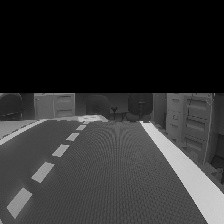

C:\Users\B-Dog\AppData\Local\Temp\ipykernel_41772\868688505.py:45: RuntimeWarning: invalid value encountered in cast
  draw_points_l = (np.asarray([lane_class.left_lane_points.reshape(-1,), lane_class.v]).T).astype(np.int32)
C:\Users\B-Dog\AppData\Local\Temp\ipykernel_41772\868688505.py:49: RuntimeWarning: invalid value encountered in cast
  draw_points_r = (np.asarray([lane_class.right_lane_points.reshape(-1,), lane_class.v]).T).astype(np.int32)


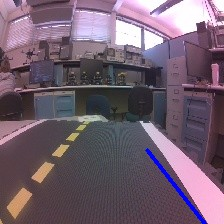

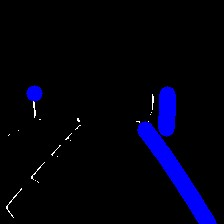

In [ ]:
visual = Visualization()
ld = Lane_Detection()
tp = Transform_Points()

img = cv2.imread('Test_Lane_Images/image_0.jpg')

edge_image = edge_detection(img)            # Detect Edges in image

ld.get_initial_lane_points(edge_image)      # Apply Lane initialization on first image
ld.solve_lane()                             # Solve lane model parameters from lane points
ld.lane_sanity_checks(edge_image)           # Apply corrections to lane model
tp.transform_lane_to_poly(ld)               # Calculate polynomial coeff from lane model

visual.draw_lane_lines(img, ld)                             # Draw lane model lines on image
edge_image = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2RGB)   # Generate Edge Image
visual.draw_lane_points(edge_image, ld)                     # Draw lane edge points on image
display(Image(data=bgr8_to_jpeg(img)))                      # Display img with drawing
display(Image(data=bgr8_to_jpeg(edge_image)))                      # Display img with drawing


In [ ]:
while const.VISUALIZE:
       clear_output(wait = True)
       img = np.array(camera.value)
       edge_image = edge_detection(img)

       for i in range(2):                      # Solve for lane model multiple times for convergence
              ld.lane_points(edge_image)      
              ld.solve_lane()                     # Solve lane model parameters from lane points
              ld.lane_sanity_checks(edge_image)   # Apply corrections to lane model
       tp.transform_lane_to_poly(ld)           # Calculate polynomial coeff from lane model

       # visual.clear_imgs()                                         # Clear Images to show every iteration
       visual.draw_lane_lines(img, ld)                             # Draw lane model lines on image
       edge_image = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2RGB)   # Generate Edge Image
       visual.draw_lane_points(edge_image, ld)                     # Draw lane edge points on image
       display(Image(data=bgr8_to_jpeg(img)))                      # Append img for drawing
       # visual.append_img(edge_image)                               # Append img for drawing
       # img = vid.bev(img)                                          # Birds Eye View transformation
       # visual.append_img(img)                                      # Append img for drawing
       # visual.show_imgs()                                          # Show images that were appended for drawing

# For Testing

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import threading
import time
import os

# # 1. Checkerboard Parameters (inner corners, square size in meters)
# CHECKERBOARD = (7, 5)  # 7 columns, 5 rows of inner corners
# SQUARE_SIZE = 0.024  # in meters (e.g., 24mm squares)

# # termination criteria
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1],3), np.float32)
# objp[:,:2] = np.mgrid[0:CHECKERBOARD[0],0:CHECKERBOARD[1]].T.reshape(-1,2)
# objp *= SQUARE_SIZE

# # Arrays to store object points and image points from all the images.
# objpoints = [] # 3d point in real world space
# imgpoints = [] # 2d points in image plane.

# 1. Setup Widgets
image = widgets.Image(format='jpeg', width=300, height=300)
save_button = widgets.Button(description='Save Image')
saved_count = 0
status_label = widgets.Label(value='Ready')
display(widgets.VBox([image, save_button, status_label]))
ret = False



# 3. Image Update Function (Threaded)
def update_image_loop():
    # global ret
    while True:
        frame = camera.value
        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
        # # If found, add object points, image points (after refining them)
        # if ret == True:
        #     corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

        #     # Draw and display the corners
        #     cv2.drawChessboardCorners(frame, CHECKERBOARD, corners2, ret)
        image.value = bgr8_to_jpeg(frame)
        time.sleep(0.01)  # control the update rate

# 3. Button Callback to Save Image
SAVE_DIR = "lane_images"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_image_callback(b):
    global saved_count
    # global objpoints
    # global imgpoints
    frame = camera.value
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    # # If found, add object points, image points (after refining them)
    # if ret == True:
    #     objpoints.append(objp)

    #     corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    #     imgpoints.append(corners2)
    if frame:
        filename = f"image_{saved_count}.jpg"
        filepath = os.path.join(SAVE_DIR, filename)
        with open(filepath, 'wb') as f:
            f.write(image.value)
        status_label.value = f"✅ Saved {filename}"
        saved_count += 1
    else:
        status_label.value = "⚠️ No image available."

# 4. Connect Callback
save_button.on_click(save_image_callback)

# 5. Start Image Update Thread (non-blocking)
threading.Thread(target=update_image_loop, daemon=True).start()


In [ ]:
# from jetbot import Robot, Camera, bgr8_to_jpeg
import cv2
import numpy as np
from IPython.display import display, Image, clear_output

In [ ]:
def bgr8_to_jpeg(image, quality=90):
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Invalid image for JPEG encoding")

    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    encode_params = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, jpeg = cv2.imencode('.jpg', image, encode_params)
    if not success:
        raise ValueError("JPEG encoding failed")
    return jpeg.tobytes()


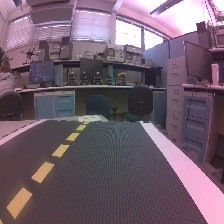

In [ ]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')
display(Image(data=bgr8_to_jpeg(image)))

In [ ]:
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)
    # Retrieve the number of color channels of the image.
    # channel_count = img.shape[2]
    # Create a match color with the same color channel counts.
    match_mask_color = 255
      
    # Fill inside the polygon
    cv2.fillPoly(mask, vertices, match_mask_color)
    
    # Returning the image only where mask pixels match
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

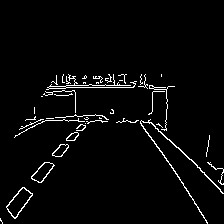

In [ ]:
height = 224
width = 224
region_of_interest_vertices = [
    (0 - width/5, height),
    (width / 4, height / 3),
    (width*3/4, height / 3),
    (width + width/5, height),
]

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
# Moved the cropping operation to the end of the pipeline.
cropped_image = region_of_interest(
    cannyed_image,
    np.array([region_of_interest_vertices], np.int32)
)

display(Image(data=bgr8_to_jpeg(cropped_image)))

In [ ]:
lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
print(lines)

[[[ 50  85 152  85]]

 [[ 13 197  87 115]]

 [[ 34 117 105 117]]

 [[ 25 120 165 120]]

 [[ 13 216  86 115]]

 [[162 152 206 220]]

 [[ 29 197  90 121]]

 [[178 147 220 189]]

 [[ 47  87 167  87]]]


In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

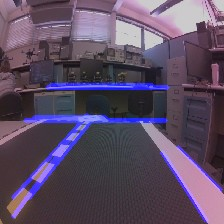

In [ ]:
line_image = draw_lines(image, lines) # <---- Add this call.
display(Image(data=bgr8_to_jpeg(line_image)))

In [ ]:
import math
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

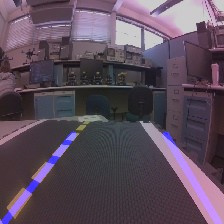

In [ ]:
min_y = int(image.shape[0] * (3 / 5)) # <-- Just below the horizon
max_y = image.shape[0] # <-- The bottom of the image
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

line_image = draw_lines(image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
    thickness=5,
)
display(Image(data=bgr8_to_jpeg(line_image)))

In [ ]:
def detect_lane_markings(image: np.ndarray):
    """
    Args:
        image: An image from the robot's camera in the BGR color space (numpy.ndarray)
    Return:
        left_masked_img:   Masked image for the dashed-yellow line (numpy.ndarray)
        right_masked_img:  Masked image for the solid-white line (numpy.ndarray)
    """
    h, w, _ = image.shape
    # print(image.shape)

    imgbgr = image

    # Convert the image to HSV for any color-based filtering
    imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

    # Most of our operations will be performed on the grayscale version
    imggray = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

    horizon_X = 130
    mask_ground = np.zeros((h, w), dtype=np.uint8)
    mask_ground[int(h - horizon_X) :, :] = 1
    # print(h," " ,w," " ,int(h - horizon_X[0]))

    sigma = 8  # CHANGE ME

    # Smooth the image using a Gaussian kernel
    img_gaussian_filter = cv2.GaussianBlur(imggray, (0, 0), sigma)

    # Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
    sobelx = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 0, 1)

    # Compute the magnitude of the gradients
    Gmag = np.sqrt(sobelx * sobelx + sobely * sobely)

    threshold_left = 5  # CHANGE ME
    mask_mag_left = Gmag > threshold_left
    threshold_right = 25
    mask_mag_right = Gmag > threshold_right

    white_lower_hsv = np.array([15, 3, 166])  # CHANGE ME
    white_upper_hsv = np.array([179, 116, 255])  # CHANGE ME
    yellow_lower_hsv = np.array([10, 75, 50])        # CHANGE ME
    yellow_upper_hsv = np.array([35, 255, 255])  # CHANGE ME

    mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    mask_left = np.ones(sobelx.shape)
    mask_left[:, int(np.floor(w / 2)) : w + 1] = 0
    mask_right = np.ones(sobelx.shape)
    mask_right[:, 0 : int(np.floor(w / 2))] = 0

    mask_sobelx_pos = sobelx > 0
    mask_sobelx_neg = sobelx < 0
    mask_sobely_neg = sobely < 0

    mask_left_edge = mask_ground * mask_left * mask_mag_left * mask_sobelx_neg * mask_sobely_neg * mask_yellow
    mask_right_edge = mask_ground * mask_right * mask_mag_right * mask_sobelx_pos * mask_sobely_neg * mask_white
    mask_lanes = np.uint8((mask_left_edge + mask_right_edge) > 0) * 255
    masked_image = cv2.bitwise_and(image, image, mask=mask_lanes)
    # display(Image(data=bgr8_to_jpeg(mask_lanes)))
    # display(Image(data=bgr8_to_jpeg(image)))

    return masked_image

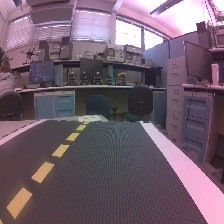

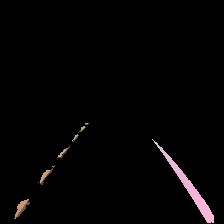

In [ ]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')
display(Image(data=bgr8_to_jpeg(image)))
edge_lines = detect_lane_markings(image)
display(Image(data=bgr8_to_jpeg(edge_lines)))

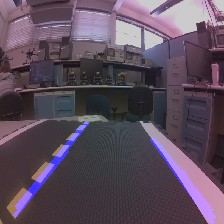

[[[152 139 212 222]]

 [[170 163 213 217]]

 [[156 142 208 206]]

 [[ 17 206  81 127]]

 [[182 171 210 220]]

 [[ 15 215  66 151]]

 [[171 166 209 219]]

 [[155 142 210 210]]

 [[ 18 208  86 123]]]


In [ ]:
gray_edge_lines = cv2.cvtColor(edge_lines, cv2.COLOR_BGR2GRAY)
lines = cv2.HoughLinesP(
    gray_edge_lines,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
line_image = draw_lines(image, lines) # <---- Add this call.
display(Image(data=bgr8_to_jpeg(line_image)))
print(lines)

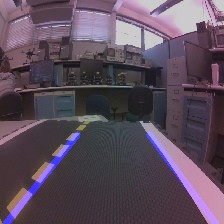

In [ ]:
import math
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

min_y = int(image.shape[0] * (3 / 5)) # <-- Just below the horizon
max_y = image.shape[0] # <-- The bottom of the image
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

line_image = draw_lines(image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
    thickness=5,
)
display(Image(data=bgr8_to_jpeg(line_image)))

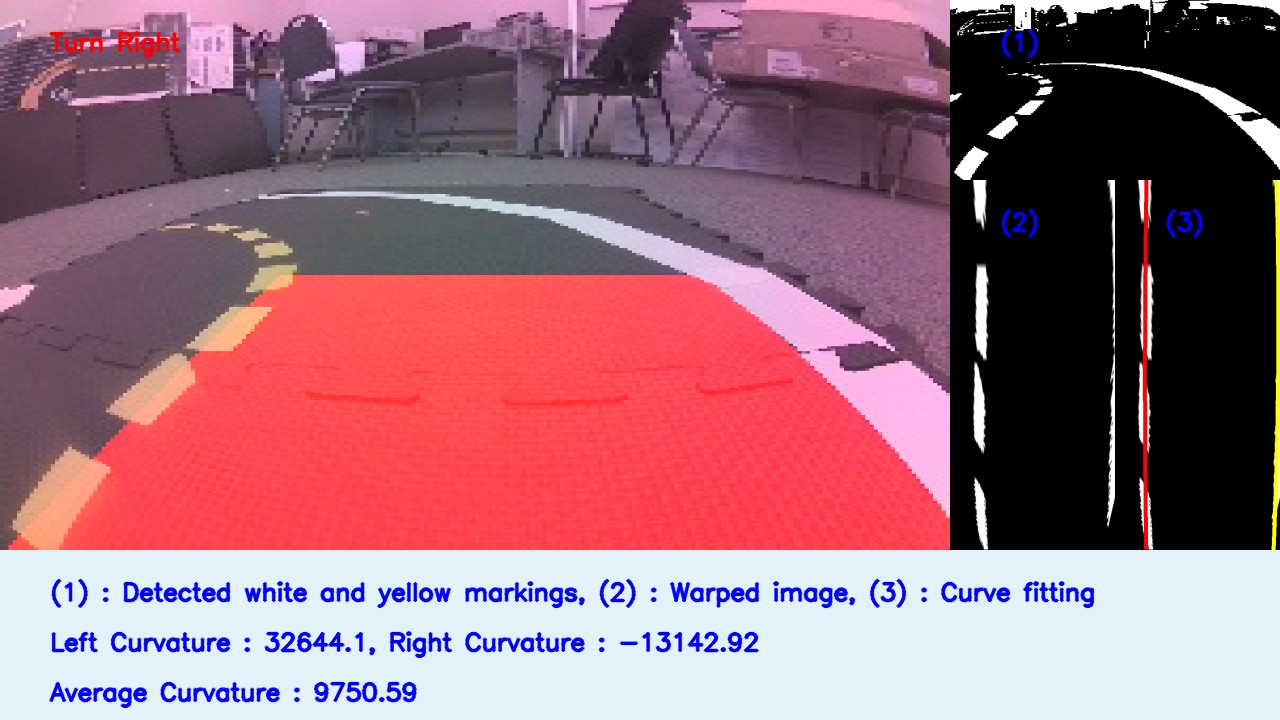

In [ ]:
#Import necessary libraries
import cv2 
import numpy as np

#Function to preprocess the image to detect yellow and white lanes
def preprocessing(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gblur = cv2.GaussianBlur(gray,(5,5),0)
    white_mask = cv2.threshold(gblur,150,255,cv2.THRESH_BINARY)[1]
    lower_yellow = np.array([0,100,100])
    upper_yellow = np.array([210,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return mask

#Function that defines the polygon region of interest
def regionOfInterest(img, polygon):
    # mask = np.zeros_like(img)
    # x1, y1 = polygon[0]
    # x2, y2 = polygon[1]
    # x3, y3 = polygon[2]
    # x4, y4 = polygon[3]
    # m1 = (y2-y1)/(x2-x1)
    # m2 = (y3-y2)/(x3-x2)
    # m3 = (y4-y3)/(x4-x3)
    # m4 = (y4-y1)/(x4-x1)
    # b1 = y1 - m1*x1
    # b2 = y2 - m2*x2
    # b3 = y3 - m3*x3
    # b4 = y4 - m4*x4
    
    # for i in range(mask.shape[0]):
    #     for j in range(mask.shape[1]):
    #         if i>=m1*j+b1 and i>=m2*j+b2 and i>=m3*j+b3 and i<=m4*j+b4:
    #             mask[i][j] = 1
    
    h, w = img.shape
    horizon_X = 130
    mask_ground = np.zeros((h, w), dtype=np.uint8)
    mask_ground[int(h - horizon_X) :, :] = 1

    masked_img = np.multiply(mask_ground, img)
    return masked_img

#Function that warps the image
def warp(img, source_points, destination_points, destn_size):
    matrix = cv2.getPerspectiveTransform(source_points, destination_points)
    warped_img = cv2.warpPerspective(img, matrix, destn_size)
    return warped_img

#Function that unwarps the image
def unwarp(img, source_points, destination_points, source_size):
    matrix = cv2.getPerspectiveTransform(destination_points, source_points)
    unwarped_img = cv2.warpPerspective(img, matrix, source_size)
    return unwarped_img

#Function that gives the left fit and right fit curves for the lanes in birdeye's view
def fitCurve(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 50
    margin = 100
    minpix = 50
    window_height = int(img.shape[0]/nwindows)
    y, x = img.nonzero()
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_indices = []
    right_lane_indices = []
    
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_indices = ((y >= win_y_low) & (y < win_y_high) & (x >= win_xleft_low) & (x < win_xleft_high)).nonzero()[0]
        good_right_indices  = ((y >= win_y_low) & (y < win_y_high) & (x >= win_xright_low) & (x < win_xright_high)).nonzero()[0]
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        if len(good_left_indices) > minpix:
            leftx_current = int(np.mean(x[good_left_indices]))
        if len(good_right_indices) > minpix:
            rightx_current = int(np.mean(x[good_right_indices]))
        
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    leftx = x[left_lane_indices]
    lefty = y[left_lane_indices]
    rightx = x[right_lane_indices]
    righty = y[right_lane_indices]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

#Function that give pixel location of points through which the curves of detected lanes passes
def findPoints(img_shape, left_fit, right_fit):
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    return pts_left, pts_right

#Function that fills the space between the detected lane curves
def fillCurves(img_shape, pts_left, pts_right):
    pts = np.hstack((pts_left, pts_right))
    img = np.zeros((img_shape[0], img_shape[1], 3), dtype='uint8')
    cv2.fillPoly(img, np.int_([pts]), (0,0, 255))
    return img

#Function that converts a one channel image into a three channel image
def oneToThreeChannel(binary):
    img = np.zeros((binary.shape[0], binary.shape[1], 3), dtype='uint8')
    img[:,:,0] = binary
    img[:,:,1] = binary
    img[:,:,2] = binary
    return img

#Function that draws the curves of detected lanes on an image
def drawCurves(img, pts_left, pts_right):
    img = oneToThreeChannel(img)
    cv2.polylines(img, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=10)
    cv2.polylines(img, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=10)
    return img

#Function that concatenates various images to one image
def concatenate(img1, img2, img3, img4, img5):
    offset = 50
    img3 = setOffset(img3, offset)
    img4 = setOffset(img4, offset)
    img1 = cv2.resize(img1, (950,550), interpolation = cv2.INTER_AREA)
    img2 = cv2.resize(img2, (330,180), interpolation = cv2.INTER_AREA)
    img3 = cv2.resize(img3, (165,370), interpolation = cv2.INTER_AREA)
    img4 = cv2.resize(img4, (165,370), interpolation = cv2.INTER_AREA)
    result = np.concatenate((img3, img4), axis = 1)
    result = np.concatenate((img2, result))
    result = np.concatenate((img1, result), axis = 1)
    result = np.concatenate((result, img5), axis = 0)
    return result

#Function that outputs the radius of curvature
def radiusOfCurvature(img, left_fit, right_fit):
    y_eval = img.shape[0]/2
    left_radius = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / (2*left_fit[0])
    right_radius = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / (2*right_fit[0])
    avg_radius = (left_radius+right_radius)/2 
    return round(left_radius,2), round(right_radius,2), round(avg_radius,2)

#Function that outputs image containing radius value
def informationWindow(left_radius, right_radius, radius):
    window = np.zeros((170, 1280, 3), dtype='uint8')
    window[:,:,0] = 249
    window[:,:,1] = 242
    window[:,:,2] = 227
    text1 = '(1) : Detected white and yellow markings, (2) : Warped image, (3) : Curve fitting'
    window = cv2.putText(window, text1, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    text2 = 'Left Curvature : ' + str(left_radius) + ', Right Curvature : ' + str(right_radius)
    window = cv2.putText(window, text2, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    text3 = 'Average Curvature : ' + str(radius)
    window = cv2.putText(window, text3, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    return window

#Function that predicts turn
def addTurnInfo(img, radius):
    if radius >= 10000:
        img = cv2.putText(img, 'Go Straight', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
    if radius >= 0 and radius < 10000:
        img = cv2.putText(img, 'Turn Right', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
    if radius <= 0:
        img = cv2.putText(img, 'Turn Left', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
    img = cv2.putText(img, '(1)', (1000,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    img = cv2.putText(img, '(2)', (1000,230), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    img = cv2.putText(img, '(3)', (1165,230), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    
    return img

#Function that adds extra blank space in front of the image
def setOffset(img, offset):
    blank = np.zeros((img.shape[0], offset, 3), dtype = 'uint8')
    img = np.concatenate((blank, img), axis = 1)
    return img

# video = cv2.VideoCapture("data/curved_lane_detection.mp4")
# out = cv2.VideoWriter('results/curve_lane_detection.avi',cv2.VideoWriter_fourcc(*'XVID'), 25, (1280,720))
# print("Generating video output...\n")
image = cv2.imread('Test_Lane_Images/image_4.jpg')

# isTrue, frame = video.read()
# if isTrue == False:
#     break
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY)[1]
processed_img = preprocessing(image)
height, width = processed_img.shape
polygon = [(int(width*0.15), int(height*0.94)), (int(width*0.45), int(height*0.62)), (int(width*0.58), int(height*0.62)), (int(0.95*width), int(0.94*height))]
masked_img = regionOfInterest(processed_img, polygon)
source_points = np.float32([
    [int(0-width/10), int(height)],  # bottom-left
    [int(width*1.1), int(height)],  # bottom-right
    [int(width*.25), int(height*0.5)],  # top-left
    [int(width*.75), int(height*0.5)]   # top-right
])
destination_points = np.float32([
    [0, 960],     # bottom-left
    [400, 960],   # bottom-right
    [0, 0],       # top-left
    [400, 0]      # top-right
])

warped_img_size = (400, 960)
warped_img_shape = (960, 400)
warped_img = warp(masked_img, source_points, destination_points, warped_img_size)
kernel = np.ones((11,11), np.uint8)
opening = cv2.morphologyEx(warped_img, cv2.MORPH_CLOSE, kernel)
left_fit, right_fit = fitCurve(opening)
pts_left, pts_right = findPoints(warped_img_shape, left_fit, right_fit)
fill_curves = fillCurves(warped_img_shape, pts_left, pts_right)
unwarped_fill_curves = unwarp(fill_curves, source_points, destination_points, (width, height))
window1 = cv2.addWeighted(image, 1, unwarped_fill_curves, 1, 0)
left_radius, right_radius, avg_radius = radiusOfCurvature(warped_img, left_fit, right_fit)
window2 = oneToThreeChannel(thresh)
window3 = oneToThreeChannel(warped_img)
window4 = drawCurves(warped_img, pts_left, pts_right)
window5 = informationWindow(left_radius, right_radius, avg_radius)
result = concatenate(window1, window2, window3, window4, window5)
result = addTurnInfo(result, avg_radius)
display(Image(data=bgr8_to_jpeg(result)))